In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [20]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [21]:
class DNN_3(nn.Module):
    def __init__(self, input_dim,hidden_units1,hidden_units2,hidden_units3,hidden_units4,dropout1,dropout2,dropout3,dropout4):
        super(DNN_3, self).__init__()
        self.layer1 = nn.Linear(input_dim,hidden_units1)
        self.layer2 = nn.Linear(hidden_units1,hidden_units2)
        self.layer3 = nn.Linear(hidden_units2, hidden_units3)
        self.layer4 = nn.Linear(hidden_units3, hidden_units4)
        self.output_layer = nn.Linear(hidden_units4, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)


        self.bn1 = nn.BatchNorm1d(hidden_units1)
        self.bn2 = nn.BatchNorm1d(hidden_units2)
        self.bn3 = nn.BatchNorm1d(hidden_units3)
        self.bn4 = nn.BatchNorm1d(hidden_units4)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [22]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [23]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    hidden_units1 = trial.suggest_int("hidden_units1", 216, 512, step=2)
    hidden_units2 = trial.suggest_int("hidden_units2", 128, 216, step=2)
    hidden_units3 = trial.suggest_int("hidden_units3", 64, 128, step=2)
    hidden_units4 = trial.suggest_int("hidden_units4", 4, 64, step=2)
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    dropout3 = trial.suggest_float("dropout3", 0, 0.5, step=0.05)
    dropout4 = trial.suggest_float("dropout4", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   

    # モデル定義
    model = DNN_3(
        input_dim=X_train_tensor.shape[1],
        hidden_units1=hidden_units1,
        hidden_units2=hidden_units2,
        hidden_units3=hidden_units3,
        hidden_units4=hidden_units4,
        dropout1=dropout1,
        dropout2=dropout2,
        dropout3=dropout3,
        dropout4=dropout4
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val).item()
                predictions = (val_outputs >= 0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 最終的な評価指標を計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [24]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-11-29 18:13:11,539] A new study created in memory with name: no-name-f8404fea-73b5-49c7-ab98-2ea5cd349012
/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:13:23,383] Trial 0 finished with value: 0.13858697343671664 and parameters: {'hidden_units1': 358, 'hidden_units2': 180, 'hidden_units3': 106, 'hidden_units4': 32, 'dropout1': 0.35000000000000003, 'dropout2': 0.2, 'dropout3': 0.350000000

Early stopping at epoch 23
Final MCC: 0.1386


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:14:10,602] Trial 1 finished with value: 0.24349642846316208 and parameters: {'hidden_units1': 512, 'hidden_units2': 190, 'hidden_units3': 128, 'hidden_units4': 26, 'dropout1': 0.4, 'dropout2': 0.05, 'dropout3': 0.0, 'dropout4': 0.5, 'learning_rate': 2.0706871635500777e-05, 'weight_decay': 0.0018077606667463205}. Best is trial 1 with value: 0.2434964

Final MCC: 0.2435


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:14:18,975] Trial 2 finished with value: 0.13293071444735113 and parameters: {'hidden_units1': 338, 'hidden_units2': 194, 'hidden_units3': 120, 'hidden_units4': 34, 'dropout1': 0.5, 'dropout2': 0.05, 'dropout3': 0.05, 'dropout4': 0.25, 'learning_rate': 0.0003950262807226454, 'weight_decay': 0.005018757134315726}. Best is trial 1 with value: 0.2434964

Early stopping at epoch 16
Final MCC: 0.1329


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:14:59,863] Trial 3 finished with value: 0.23018478852669574 and parameters: {'hidden_units1': 470, 'hidden_units2': 180, 'hidden_units3': 86, 'hidden_units4': 30, 'dropout1': 0.1, 'dropout2': 0.15000000000000002, 'dropout3': 0.1, 'dropout4': 0.45, 'learning_rate': 1.8934322164999886e-05, 'weight_decay': 5.8508219906621046e-05}. Best is trial 1 with 

Early stopping at epoch 81
Final MCC: 0.2302


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:15:06,357] Trial 4 finished with value: 0.12900094070966361 and parameters: {'hidden_units1': 472, 'hidden_units2': 132, 'hidden_units3': 90, 'hidden_units4': 62, 'dropout1': 0.0, 'dropout2': 0.35000000000000003, 'dropout3': 0.45, 'dropout4': 0.1, 'learning_rate': 0.0022648806940500157, 'weight_decay': 2.1777700543146233e-05}. Best is trial 1 with v

Early stopping at epoch 12
Final MCC: 0.1290


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:15:06,843] Trial 5 pruned. 
[I 2024-11-29 18:15:13,118] Trial 6 pruned. 
[I 2024-11-29 18:15:13,608] Trial 7 pruned. 
[I 2024-11-29 18:15:43,882] Trial 8 finished with value: 0.04065785563073631 and parameters: {'hidden_units1': 290, 'hidden_units2': 134, 'hidden_units3': 84, 'hidden_units4': 6, 'dropout1': 0.0, 'dropout2': 0.5, 'dropout3': 0.25, 'd

Early stopping at epoch 65
Final MCC: 0.0407


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:16:07,875] Trial 9 finished with value: 0.17142035303058445 and parameters: {'hidden_units1': 490, 'hidden_units2': 156, 'hidden_units3': 64, 'hidden_units4': 18, 'dropout1': 0.0, 'dropout2': 0.05, 'dropout3': 0.5, 'dropout4': 0.15000000000000002, 'learning_rate': 3.116314276527179e-05, 'weight_decay': 9.09032508297063e-05}. Best is trial 1 with val

Early stopping at epoch 50
Final MCC: 0.1714


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:16:22,875] Trial 10 finished with value: 0.17432882157978116 and parameters: {'hidden_units1': 416, 'hidden_units2': 212, 'hidden_units3': 110, 'hidden_units4': 48, 'dropout1': 0.35000000000000003, 'dropout2': 0.0, 'dropout3': 0.0, 'dropout4': 0.5, 'learning_rate': 6.43080176839468e-05, 'weight_decay': 0.0012152072715955727}. Best is trial 1 with va

Early stopping at epoch 32
Final MCC: 0.1743


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:16:47,907] Trial 11 finished with value: 0.2244755939415051 and parameters: {'hidden_units1': 508, 'hidden_units2': 202, 'hidden_units3': 76, 'hidden_units4': 22, 'dropout1': 0.2, 'dropout2': 0.1, 'dropout3': 0.15000000000000002, 'dropout4': 0.5, 'learning_rate': 7.75069355736213e-05, 'weight_decay': 1.717912618811086e-05}. Best is trial 1 with valu

Early stopping at epoch 52
Final MCC: 0.2245


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:17:29,848] Trial 12 finished with value: 0.31873377739185427 and parameters: {'hidden_units1': 420, 'hidden_units2': 190, 'hidden_units3': 78, 'hidden_units4': 44, 'dropout1': 0.35000000000000003, 'dropout2': 0.30000000000000004, 'dropout3': 0.1, 'dropout4': 0.4, 'learning_rate': 1.0106621852338477e-05, 'weight_decay': 0.0010431117396393526}. Best i

Early stopping at epoch 88
Final MCC: 0.3187


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:17:30,404] Trial 13 pruned. 
[I 2024-11-29 18:18:17,746] Trial 14 finished with value: 0.27189813344859487 and parameters: {'hidden_units1': 430, 'hidden_units2': 192, 'hidden_units3': 128, 'hidden_units4': 46, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dropout3': 0.15000000000000002, 'dropout4': 0.35000000000000003, 'learning_rate': 1.16434

Final MCC: 0.2719


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:18:18,299] Trial 15 pruned. 
[I 2024-11-29 18:19:05,263] Trial 16 finished with value: 0.3156692237509533 and parameters: {'hidden_units1': 376, 'hidden_units2': 168, 'hidden_units3': 80, 'hidden_units4': 44, 'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'dropout3': 0.35000000000000003, 'dropout4': 0.35000000000000003, 'learning_rate': 1.001906

Final MCC: 0.3157


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:19:53,334] Trial 17 finished with value: 0.3593773493721308 and parameters: {'hidden_units1': 316, 'hidden_units2': 168, 'hidden_units3': 78, 'hidden_units4': 56, 'dropout1': 0.5, 'dropout2': 0.5, 'dropout3': 0.4, 'dropout4': 0.4, 'learning_rate': 5.064362642272924e-05, 'weight_decay': 0.0006910524407890147}. Best is trial 17 with value: 0.359377349

Final MCC: 0.3594


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:20:30,676] Trial 18 finished with value: 0.34185499394129104 and parameters: {'hidden_units1': 316, 'hidden_units2': 168, 'hidden_units3': 72, 'hidden_units4': 56, 'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.35000000000000003, 'dropout4': 0.4, 'learning_rate': 3.837083638621527e-05, 'weight_decay': 0.00024560534996468893}. Best is trial 17 with 

Early stopping at epoch 78
Final MCC: 0.3419


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:20:31,246] Trial 19 pruned. 
[I 2024-11-29 18:21:19,991] Trial 20 finished with value: 0.16683392460785923 and parameters: {'hidden_units1': 290, 'hidden_units2': 166, 'hidden_units3': 64, 'hidden_units4': 56, 'dropout1': 0.25, 'dropout2': 0.45, 'dropout3': 0.30000000000000004, 'dropout4': 0.4, 'learning_rate': 4.6683182564145916e-05, 'weight_decay'

Final MCC: 0.1668


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:21:20,513] Trial 21 pruned. 
[I 2024-11-29 18:21:21,056] Trial 22 pruned. 
[I 2024-11-29 18:22:08,348] Trial 23 finished with value: 0.16104562553860188 and parameters: {'hidden_units1': 262, 'hidden_units2': 184, 'hidden_units3': 96, 'hidden_units4': 58, 'dropout1': 0.45, 'dropout2': 0.5, 'dropout3': 0.5, 'dropout4': 0.4, 'learning_rate': 3.2970924

Final MCC: 0.1610


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:22:08,903] Trial 24 pruned. 
[I 2024-11-29 18:22:50,602] Trial 25 finished with value: 0.3598309742236164 and parameters: {'hidden_units1': 356, 'hidden_units2': 144, 'hidden_units3': 94, 'hidden_units4': 38, 'dropout1': 0.15000000000000002, 'dropout2': 0.35000000000000003, 'dropout3': 0.45, 'dropout4': 0.45, 'learning_rate': 2.182393111024351e-05, 

Early stopping at epoch 86
Final MCC: 0.3598


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:22:51,121] Trial 26 pruned. 
[I 2024-11-29 18:23:20,860] Trial 27 finished with value: 0.37020631287128414 and parameters: {'hidden_units1': 260, 'hidden_units2': 146, 'hidden_units3': 88, 'hidden_units4': 52, 'dropout1': 0.15000000000000002, 'dropout2': 0.45, 'dropout3': 0.45, 'dropout4': 0.30000000000000004, 'learning_rate': 2.5428500815980566e-05

Early stopping at epoch 62
Final MCC: 0.3702


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:23:54,595] Trial 28 finished with value: 0.2740472876035875 and parameters: {'hidden_units1': 264, 'hidden_units2': 146, 'hidden_units3': 90, 'hidden_units4': 52, 'dropout1': 0.05, 'dropout2': 0.35000000000000003, 'dropout3': 0.45, 'dropout4': 0.25, 'learning_rate': 1.7603660283931186e-05, 'weight_decay': 0.000104799132461864}. Best is trial 27 with

Early stopping at epoch 71
Final MCC: 0.2740


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:23:55,139] Trial 29 pruned. 
[I 2024-11-29 18:23:55,703] Trial 30 pruned. 
[I 2024-11-29 18:23:56,232] Trial 31 pruned. 
[I 2024-11-29 18:24:32,279] Trial 32 finished with value: 0.34814773327347187 and parameters: {'hidden_units1': 356, 'hidden_units2': 150, 'hidden_units3': 88, 'hidden_units4': 58, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.4

Early stopping at epoch 72
Final MCC: 0.3481


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:24:32,881] Trial 33 pruned. 
[I 2024-11-29 18:25:06,654] Trial 34 finished with value: 0.27490258014691055 and parameters: {'hidden_units1': 388, 'hidden_units2': 138, 'hidden_units3': 86, 'hidden_units4': 52, 'dropout1': 0.05, 'dropout2': 0.45, 'dropout3': 0.5, 'dropout4': 0.45, 'learning_rate': 9.9215833838228e-05, 'weight_decay': 0.00150774526772

Early stopping at epoch 71
Final MCC: 0.2749


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:25:54,790] Trial 35 finished with value: 0.3173384123513382 and parameters: {'hidden_units1': 342, 'hidden_units2': 160, 'hidden_units3': 94, 'hidden_units4': 32, 'dropout1': 0.25, 'dropout2': 0.35000000000000003, 'dropout3': 0.45, 'dropout4': 0.30000000000000004, 'learning_rate': 2.152994790001245e-05, 'weight_decay': 1.0428584002294302e-05}. Best 

Final MCC: 0.3173


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:26:31,053] Trial 36 finished with value: 0.3225307463503984 and parameters: {'hidden_units1': 368, 'hidden_units2': 148, 'hidden_units3': 100, 'hidden_units4': 62, 'dropout1': 0.05, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.35000000000000003, 'learning_rate': 1.5195641388970248e-05, 'weight_decay': 0.0001835523231782021}. Best is trial 27 with

Early stopping at epoch 78
Final MCC: 0.3225


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:27:17,579] Trial 37 finished with value: 0.31700439792319157 and parameters: {'hidden_units1': 278, 'hidden_units2': 136, 'hidden_units3': 86, 'hidden_units4': 40, 'dropout1': 0.1, 'dropout2': 0.25, 'dropout3': 0.30000000000000004, 'dropout4': 0.5, 'learning_rate': 2.3791721231864104e-05, 'weight_decay': 0.0007515688427125125}. Best is trial 27 with

Early stopping at epoch 99
Final MCC: 0.3170


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:27:52,728] Trial 38 finished with value: 0.11996731359698218 and parameters: {'hidden_units1': 334, 'hidden_units2': 128, 'hidden_units3': 82, 'hidden_units4': 26, 'dropout1': 0.25, 'dropout2': 0.35000000000000003, 'dropout3': 0.35000000000000003, 'dropout4': 0.4, 'learning_rate': 5.283350225887581e-05, 'weight_decay': 6.689332006130878e-05}. Best i

Early stopping at epoch 75
Final MCC: 0.1200


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:27:53,291] Trial 39 pruned. 
[I 2024-11-29 18:28:43,149] Trial 40 finished with value: 0.2901083796939586 and parameters: {'hidden_units1': 244, 'hidden_units2': 174, 'hidden_units3': 106, 'hidden_units4': 60, 'dropout1': 0.2, 'dropout2': 0.45, 'dropout3': 0.5, 'dropout4': 0.45, 'learning_rate': 1.539150679830104e-05, 'weight_decay': 0.0001277267567

Final MCC: 0.2901


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:29:12,488] Trial 41 finished with value: 0.34659191007765316 and parameters: {'hidden_units1': 316, 'hidden_units2': 156, 'hidden_units3': 74, 'hidden_units4': 56, 'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.4, 'dropout4': 0.4, 'learning_rate': 4.18722415280646e-05, 'weight_decay': 0.00026112203523772986}. Best is trial 27 with value: 0.37020631

Early stopping at epoch 62
Final MCC: 0.3466


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:29:13,034] Trial 42 pruned. 
[I 2024-11-29 18:29:13,461] Trial 43 pruned. 
[I 2024-11-29 18:29:13,972] Trial 44 pruned. 
[I 2024-11-29 18:29:14,533] Trial 45 pruned. 
[I 2024-11-29 18:29:56,443] Trial 46 finished with value: 0.3429199272623737 and parameters: {'hidden_units1': 322, 'hidden_units2': 152, 'hidden_units3': 78, 'hidden_units4': 20, 'dro

Early stopping at epoch 92
Final MCC: 0.3429


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:29:57,009] Trial 47 pruned. 
[I 2024-11-29 18:29:57,612] Trial 48 pruned. 
[I 2024-11-29 18:29:58,155] Trial 49 pruned. 
[I 2024-11-29 18:29:58,816] Trial 50 pruned. 
[I 2024-11-29 18:30:46,204] Trial 51 finished with value: 0.3350670380926767 and parameters: {'hidden_units1': 326, 'hidden_units2': 152, 'hidden_units3': 78, 'hidden_units4': 10, 'dro

Final MCC: 0.3351


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:30:46,755] Trial 52 pruned. 
[I 2024-11-29 18:30:47,207] Trial 53 pruned. 
[I 2024-11-29 18:30:47,705] Trial 54 pruned. 
[I 2024-11-29 18:30:48,277] Trial 55 pruned. 
[I 2024-11-29 18:30:48,869] Trial 56 pruned. 
[I 2024-11-29 18:31:37,333] Trial 57 finished with value: 0.19392271369917016 and parameters: {'hidden_units1': 326, 'hidden_units2': 146,

Final MCC: 0.1939


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:32:06,731] Trial 58 finished with value: 0.33139055647643245 and parameters: {'hidden_units1': 288, 'hidden_units2': 164, 'hidden_units3': 72, 'hidden_units4': 20, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dropout3': 0.30000000000000004, 'dropout4': 0.35000000000000003, 'learning_rate': 1.9755538082184603e-05, 'weight_decay': 0.000205942309

Early stopping at epoch 64
Final MCC: 0.3314


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:32:07,232] Trial 59 pruned. 
[I 2024-11-29 18:32:07,757] Trial 60 pruned. 
[I 2024-11-29 18:32:40,623] Trial 61 finished with value: 0.31423986908578294 and parameters: {'hidden_units1': 320, 'hidden_units2': 174, 'hidden_units3': 70, 'hidden_units4': 54, 'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.35000000000000003, 'dropout4': 0.4, 'learning_r

Final MCC: 0.3142


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:33:02,176] Trial 62 finished with value: 0.375659820518351 and parameters: {'hidden_units1': 350, 'hidden_units2': 170, 'hidden_units3': 74, 'hidden_units4': 56, 'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.4, 'dropout4': 0.4, 'learning_rate': 3.727153088108693e-05, 'weight_decay': 0.00015951226209012684}. Best is trial 62 with value: 0.375659820

Early stopping at epoch 61
Final MCC: 0.3757


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:33:02,598] Trial 63 pruned. 
[I 2024-11-29 18:33:03,168] Trial 64 pruned. 
[I 2024-11-29 18:33:03,553] Trial 65 pruned. 
[I 2024-11-29 18:33:31,239] Trial 66 finished with value: 0.32476190476190475 and parameters: {'hidden_units1': 334, 'hidden_units2': 158, 'hidden_units3': 94, 'hidden_units4': 58, 'dropout1': 0.15000000000000002, 'dropout2': 0.5,

Early stopping at epoch 90
Final MCC: 0.3248


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:34:01,154] Trial 67 finished with value: 0.36122842845426706 and parameters: {'hidden_units1': 298, 'hidden_units2': 152, 'hidden_units3': 76, 'hidden_units4': 46, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.45, 'learning_rate': 4.0390987618499546e-05, 'weight_decay': 0.0003755094293875973}. Best is trial 62 with value: 0.375659

Early stopping at epoch 58
Final MCC: 0.3612


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:34:01,548] Trial 68 pruned. 
[I 2024-11-29 18:34:02,202] Trial 69 pruned. 
[I 2024-11-29 18:34:02,867] Trial 70 pruned. 
[I 2024-11-29 18:34:28,791] Trial 71 finished with value: 0.24565294404260146 and parameters: {'hidden_units1': 272, 'hidden_units2': 152, 'hidden_units3': 78, 'hidden_units4': 52, 'dropout1': 0.15000000000000002, 'dropout2': 0.45

Early stopping at epoch 60
Final MCC: 0.2457


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:34:29,465] Trial 72 pruned. 
[I 2024-11-29 18:34:30,126] Trial 73 pruned. 
[I 2024-11-29 18:34:30,818] Trial 74 pruned. 
[I 2024-11-29 18:34:31,506] Trial 75 pruned. 
[I 2024-11-29 18:34:32,117] Trial 76 pruned. 
[I 2024-11-29 18:34:32,784] Trial 77 pruned. 
[I 2024-11-29 18:34:33,459] Trial 78 pruned. 
[I 2024-11-29 18:34:34,142] Trial 79 pruned. 


Final MCC: 0.3187


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:35:29,650] Trial 84 pruned. 
[I 2024-11-29 18:36:14,846] Trial 85 finished with value: 0.26156697873886303 and parameters: {'hidden_units1': 302, 'hidden_units2': 160, 'hidden_units3': 78, 'hidden_units4': 62, 'dropout1': 0.1, 'dropout2': 0.35000000000000003, 'dropout3': 0.30000000000000004, 'dropout4': 0.4, 'learning_rate': 2.8112962729744975e-05, 

Early stopping at epoch 86
Final MCC: 0.2616


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:36:15,538] Trial 86 pruned. 
[I 2024-11-29 18:36:16,125] Trial 87 pruned. 
[I 2024-11-29 18:36:16,511] Trial 88 pruned. 
[I 2024-11-29 18:36:16,899] Trial 89 pruned. 
[I 2024-11-29 18:36:43,194] Trial 90 finished with value: 0.2168978427216907 and parameters: {'hidden_units1': 232, 'hidden_units2': 148, 'hidden_units3': 64, 'hidden_units4': 54, 'dro

Early stopping at epoch 83
Final MCC: 0.2169


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:37:30,320] Trial 91 finished with value: 0.34659191007765316 and parameters: {'hidden_units1': 270, 'hidden_units2': 150, 'hidden_units3': 78, 'hidden_units4': 12, 'dropout1': 0.5, 'dropout2': 0.45, 'dropout3': 0.5, 'dropout4': 0.2, 'learning_rate': 2.6751521968883834e-05, 'weight_decay': 2.7612923215669338e-05}. Best is trial 62 with value: 0.37565

Final MCC: 0.3466


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:37:31,013] Trial 92 pruned. 
[I 2024-11-29 18:38:16,851] Trial 93 finished with value: 0.23449964176708632 and parameters: {'hidden_units1': 266, 'hidden_units2': 140, 'hidden_units3': 78, 'hidden_units4': 16, 'dropout1': 0.45, 'dropout2': 0.25, 'dropout3': 0.45, 'dropout4': 0.2, 'learning_rate': 1.777834646576693e-05, 'weight_decay': 3.534836601409

Final MCC: 0.2345


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:39:01,271] Trial 94 finished with value: 0.32632285979817255 and parameters: {'hidden_units1': 254, 'hidden_units2': 154, 'hidden_units3': 74, 'hidden_units4': 14, 'dropout1': 0.45, 'dropout2': 0.5, 'dropout3': 0.5, 'dropout4': 0.2, 'learning_rate': 4.4518022638176594e-05, 'weight_decay': 2.2926327698264402e-05}. Best is trial 62 with value: 0.37565

Final MCC: 0.3263


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:39:45,836] Trial 95 finished with value: 0.0988095238095238 and parameters: {'hidden_units1': 314, 'hidden_units2': 144, 'hidden_units3': 82, 'hidden_units4': 8, 'dropout1': 0.5, 'dropout2': 0.45, 'dropout3': 0.45, 'dropout4': 0.1, 'learning_rate': 2.2820685520628485e-05, 'weight_decay': 1.6979732252936117e-05}. Best is trial 62 with value: 0.375659

Early stopping at epoch 91
Final MCC: 0.0988


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:39:46,208] Trial 96 pruned. 
[I 2024-11-29 18:39:46,884] Trial 97 pruned. 
[I 2024-11-29 18:40:19,154] Trial 98 finished with value: 0.3622923634013659 and parameters: {'hidden_units1': 304, 'hidden_units2': 152, 'hidden_units3': 88, 'hidden_units4': 48, 'dropout1': 0.15000000000000002, 'dropout2': 0.4, 'dropout3': 0.5, 'dropout4': 0.4, 'learning_ra

Early stopping at epoch 93
Final MCC: 0.3623


/tmp/ipykernel_184762/2256069125.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/2256069125.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-11-29 18:40:19,546] Trial 99 pruned. 


Best Parameters:  {'hidden_units1': 350, 'hidden_units2': 170, 'hidden_units3': 74, 'hidden_units4': 56, 'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.4, 'dropout4': 0.4, 'learning_rate': 3.727153088108693e-05, 'weight_decay': 0.00015951226209012684}
Best Validation F1:  0.375659820518351


Epoch [1/100], Loss: 0.7100
Epoch [1/100], Train Loss: 0.7100, Val Loss: 0.6722
Epoch [2/100], Loss: 0.6973
Epoch [2/100], Train Loss: 0.6973, Val Loss: 0.6627
Epoch [3/100], Loss: 0.6872
Epoch [3/100], Train Loss: 0.6872, Val Loss: 0.6507
Epoch [4/100], Loss: 0.6760
Epoch [4/100], Train Loss: 0.6760, Val Loss: 0.6449
Epoch [5/100], Loss: 0.6638
Epoch [5/100], Train Loss: 0.6638, Val Loss: 0.6353
Epoch [6/100], Loss: 0.6537
Epoch [6/100], Train Loss: 0.6537, Val Loss: 0.6253
Epoch [7/100], Loss: 0.6529
Epoch [7/100], Train Loss: 0.6529, Val Loss: 0.6168
Epoch [8/100], Loss: 0.6354
Epoch [8/100], Train Loss: 0.6354, Val Loss: 0.6104
Epoch [9/100], Loss: 0.6340
Epoch [9/100], Train Loss: 0.6340, Val Loss: 0.6087
Epoch [10/100], Loss: 0.6314
Epoch [10/100], Train Loss: 0.6314, Val Loss: 0.6011
Epoch [11/100], Loss: 0.6191
Epoch [11/100], Train Loss: 0.6191, Val Loss: 0.5988
Epoch [12/100], Loss: 0.6212
Epoch [12/100], Train Loss: 0.6212, Val Loss: 0.5956
Epoch [13/100], Loss: 0.6252
Epoch

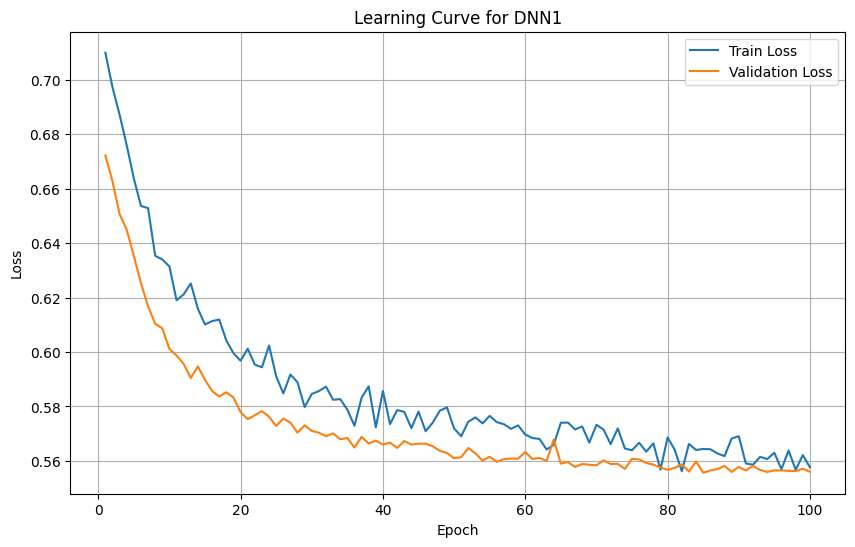

In [25]:
best_params=study.best_params
model = DNN_3(input_dim=X_train_tensor.shape[1],
              hidden_units1=best_params["hidden_units1"],
              hidden_units2=best_params["hidden_units2"],
              hidden_units3=best_params["hidden_units3"],
              hidden_units4=best_params["hidden_units4"],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              dropout3=best_params["dropout3"],
              dropout4=best_params["dropout4"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.88%
Precision: 0.4809
Recall: 0.8171
F1 Score: 0.6055
Matthews Correlation Coefficient: 0.2689
Specificity: 0.4453


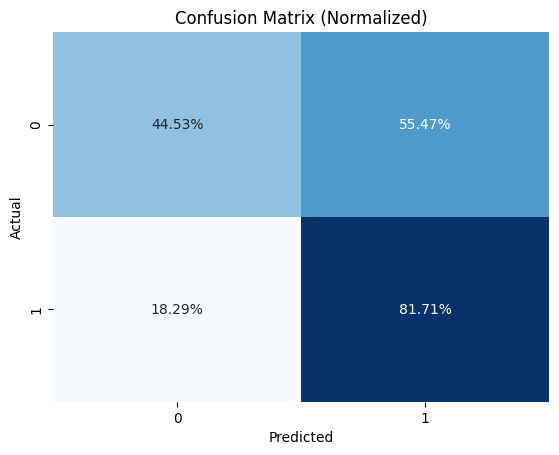

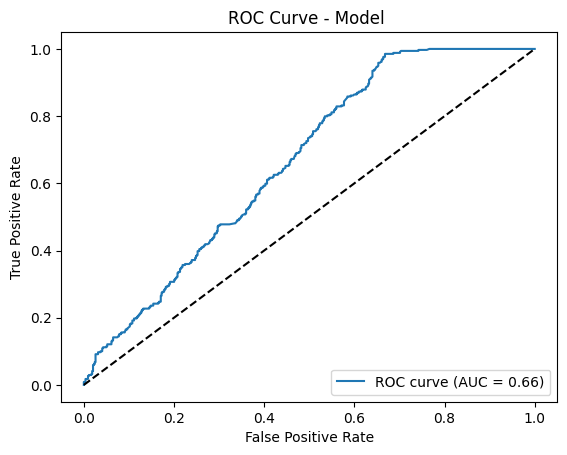

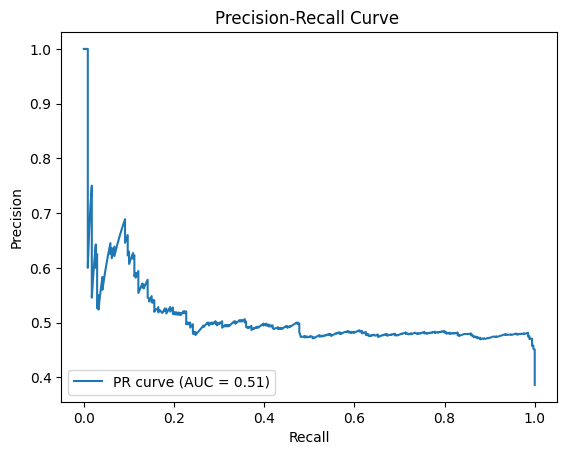

In [26]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [27]:
# モデルと構造を保存
torch.save(model, '../../saved_model/DNN_3.pth')
